<a href="https://colab.research.google.com/github/florencevivier/insurance-cross-sell-prediction/blob/main/Project_ML_Cross_Selling_Polizze_Assic_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis

## Importation of the dataset, and first considerations

In [ ]:
import pandas as pd
from scipy.stats.contingency import association
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss, roc_auc_score, f1_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

%matplotlib inline

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/insurance_cross_sell.csv")
print(df.shape)
print(df.columns)

(381109, 12)
Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')


This dataset contains 381 109 examples. </br>
The first column corresponds to an ID number, and will be dropped as it is not usefull for the rest of this study.

In [ ]:
df = df.drop("id", axis=1)

In [ ]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 32.0+ MB


The target of this study is Response, in the last column: 1 is a positive answer from the customer, 0 a negative one. </br>
Among the 10 features, info() function returns that 3 are floats, 5 are integers and 3 are objects. </br>
A deeper analysis of each is required, in order to better understand them and already decide about some transformation to apply.

## Univariate Analysis
### Gender

In [ ]:
def perc_count(y):
  counts = y.value_counts()
  mod_0 = y.unique()[0]
  mod_1 =y.unique()[1]
  print(f"{mod_0} = {counts[mod_0]} (corresponding to {counts[mod_0]/counts.sum()*100:.2f}%)")
  print(f"{mod_1} = {counts[mod_1]} (corresponding to {counts[mod_1]/counts.sum()*100:.2f}%)")

perc_count(df["Gender"])

Male = 206089 (corresponding to 54.08%)
Female = 175020 (corresponding to 45.92%)


There is a light majority of men, as they represent 54% of the examples. </br>
This variable is encoded through label encoding:  0 means male and 1 female.

In [ ]:
gender_mapping = {"Male": 0, "Female": 1}
df["Gender"] = df["Gender"].map(gender_mapping)

### Age

In [ ]:
print(df["Age"].describe())

count    381109.000000
mean         38.822584
std          15.511611
min          20.000000
25%          25.000000
50%          36.000000
75%          49.000000
max          85.000000
Name: Age, dtype: float64


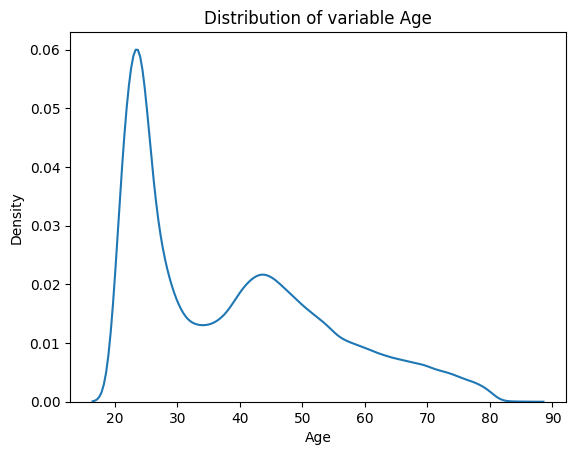

In [ ]:
sns.kdeplot(df["Age"])
plt.xlabel("Age")
plt.ylabel("Density")
plt.title("Distribution of variable Age")
plt.show()

Age values are in the range [20 ; 85] years old. The mean is about 39 years old, the median is 36. </br>
Visually, 2 populations are visible: one centered at around 25 years old, and the other one centered at 45. </br>


### Driving_License

In [ ]:
perc_count(df["Driving_License"])

1 = 380297 (corresponding to 99.79%)
0 = 812 (corresponding to 0.21%)


1 means the person has a driving license, 0 he doesn't.
In this dataset, 99.79% of the examples have one.

### Region_Code

In [ ]:
print(f"Modalities number: {df['Region_Code'].nunique()}, with a minimum of {df['Region_Code'].min()} and a maximum of {df['Region_Code'].max()}")

Modalities number: 53, with a minimum of 0.0 and a maximum of 52.0


This variable presents 53 different modalities.</br>
In order to understand how the examples are distributed, a bar plot is created.

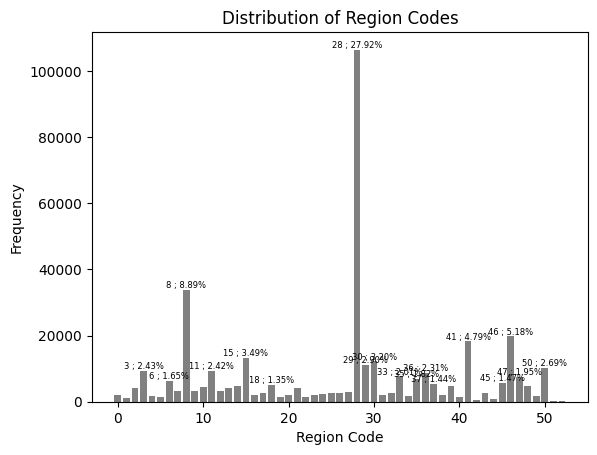

In [ ]:
region_counts = df['Region_Code'].value_counts()

# Creation of the bar plot
fig, ax = plt.subplots()
bars = ax.bar(region_counts.index, region_counts.values, color='grey')

# Add labels only to bars that exceed the threshold
threshold = 5000
for bar in bars:
    height = bar.get_height()

    if height > threshold:
        percentage = f'{(height/df.shape[0]*100):.2f}'  # Format percentage
        ax.text(bar.get_x()+.4, height, f'{ceil(bar.get_x())} ; {percentage}%', ha='center', va='bottom', fontsize = 6)

# Display the plot
plt.xlabel('Region Code')
plt.ylabel('Frequency')
plt.title('Distribution of Region Codes')
plt.show()

The modality 28 is mainly represented with nearly 28% of the examples of the dataset.

Later on in this report, this feature will be codified and the modalities with frequencies lower than 5 000 will be grouped in a unique category.


### Previously_Insured



In [ ]:
perc_count(df["Previously_Insured"])

0 = 206481 (corresponding to 54.18%)
1 = 174628 (corresponding to 45.82%)


Here 0 means the client hasn't any insured vehicle, 1 means he has. </br>
There is a light majority (54%) of clients whithout vehicle insurance.

### Vehicle_Age

In [ ]:
df_vehicle = df["Vehicle_Age"].value_counts()
print(df_vehicle)

Vehicle_Age
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: count, dtype: int64


Data of this variable are divided in 3 different classes: </br>
* inf to 1 year
* 1-2 year
* sup to 2 years

Let's plot it using a bar plot from the youngest to the oldest vehicle age.


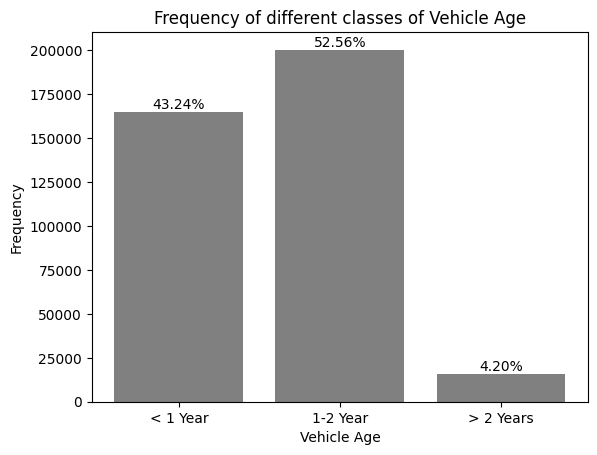

In [ ]:
fig, ax = plt.subplots()
index = ['< 1 Year', '1-2 Year', '> 2 Years']
values = [df_vehicle.loc['< 1 Year'], df_vehicle.loc['1-2 Year'], df_vehicle.loc['> 2 Years']]
bars = ax.bar(index, values, color='grey')

for bar, value in zip(bars, values):
    height = bar.get_height()
    percentage = f"{(value / df.shape[0] * 100):.2f}"
    ax.text(bar.get_x()+.4, height, f'{percentage}%', ha='center', va='bottom', fontsize = 10)

plt.xlabel('Vehicle Age')
plt.ylabel('Frequency')
plt.title('Frequency of different classes of Vehicle Age')
plt.show()

96 % of the vehicles have less than 2 years.

This variable is codified with 0 means lower than 1 year, 1 means between 1 and 2 years, and 2 means more than 2 years.

In [ ]:
age_mapping = {"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2}
df["Vehicle_Age"] = df["Vehicle_Age"].map(age_mapping)

### Vehicle_Damage

In [ ]:
perc_count(df["Vehicle_Damage"])

Yes = 192413 (corresponding to 50.49%)
No = 188696 (corresponding to 49.51%)


Yes means that the client already had accident or some damage to the vehicle, No he hadn't.
It is a case of nearly perfect equality between the 2 classes. </br>
This variable is codified with 0 means no past damage on the client vehicle and 1 means that some damage happened to it.

In [ ]:
damage_mapping = {"No": 0, "Yes": 1}
df["Vehicle_Damage"] = df["Vehicle_Damage"].map(damage_mapping)

### Annual_Premium

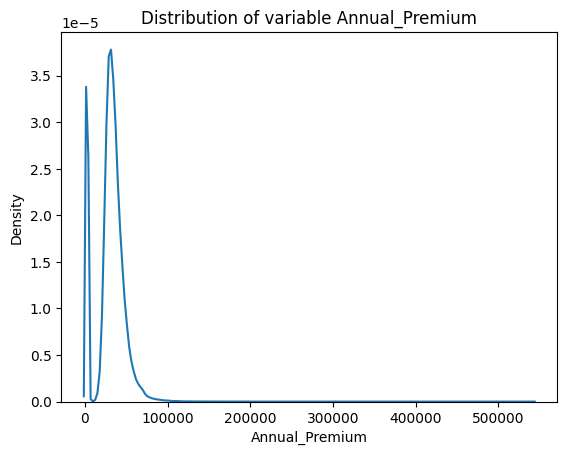

In [ ]:
sns.kdeplot(df["Annual_Premium"])
plt.xlabel("Annual_Premium")
plt.ylabel("Density")
plt.title("Distribution of variable Annual_Premium")
plt.show()

This variable has a very asymmetric distribution, with a very long queue towards high values.
To better understand it, it is suitable to do an histogramm zoomed on low values (in [0 ; 100 000] range).

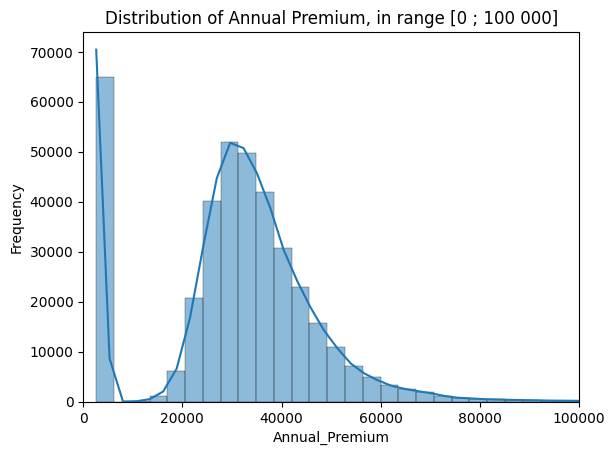

In [ ]:
figure, ax = plt.subplots()
sns.histplot(df['Annual_Premium'], kde=True, ax=ax, bins=150)
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Annual Premium, in range [0 ; 100 000]')
ax.set_xlim(0, 100000)
plt.show()

There is a very high frequency for lower values, then the distribution presents a gaussian centered at 30 000 with positive skewness, with very low frequency from 80 000. </br>

### Policy_Sales_Channel


In [ ]:
print(df["Policy_Sales_Channel"].nunique())

155


This feature represents, for each client, the channel used to propose a vehicle insurance.
There are 155 different possible channels.

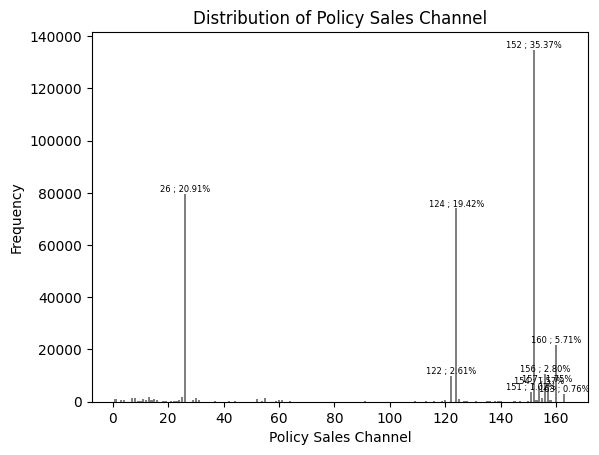

In [ ]:
channel_counts = df['Policy_Sales_Channel'].value_counts()

# Creation of the bar plot
fig, ax = plt.subplots()
bars = ax.bar(channel_counts.index, channel_counts.values, color='grey')

# Add labels only to bars that exceed the threshold
threshold = 2000
for bar in bars:
    height = bar.get_height()

    if height > threshold:
        percentage = f'{(height/df.shape[0]*100):.2f}'
        ax.text(bar.get_x()+.4, height, f'{ceil(bar.get_x())} ; {percentage}%', ha='center', va='bottom', fontsize = 6)

# Display the plot
plt.xlabel('Policy Sales Channel')
plt.ylabel('Frequency')
plt.title('Distribution of Policy Sales Channel')
plt.show()

The modality 152 is mainly represented with 35% of the examples of the dataset.

Later on in this report, this feature will be codified, and grouped together the modalities with frequencies lower than 2 000 in a unique category.

### Vintage

This quantitative variable indicates from how long the client has been insured in this compagny.

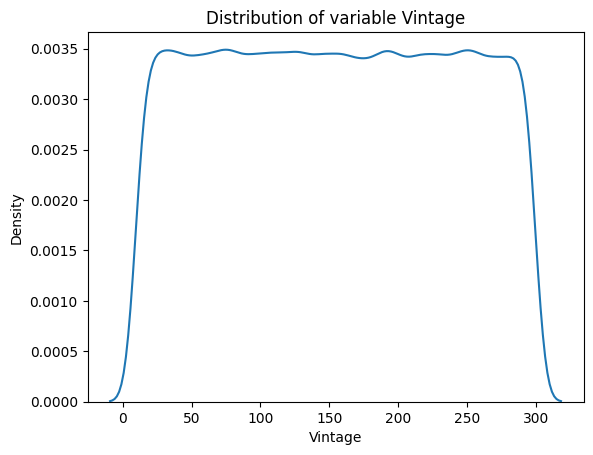

In [ ]:
sns.kdeplot(df["Vintage"])
plt.xlabel("Vintage")
plt.ylabel("Density")
plt.title("Distribution of variable Vintage")
plt.show()

In [ ]:
print(f" Minimum value : {df['Vintage'].min()} ; Maximum value : {df['Vintage'].max()}")

 Minimum value : 10 ; Maximum value : 299


It seems that from 10 to 299, all values are equally frequent.

### Response

Last but not least Response variable, which corresponds to the target. </br>
1 means the client responded positively and signed up for a vehicle inssurance ; 0 means he refuses the offer.

In [ ]:
perc_count(df["Response"])

1 = 46710 (corresponding to 12.26%)
0 = 334399 (corresponding to 87.74%)


A dataset where only 12% of the examples belong to the positive class is defined as imbalanced.
In order to obtain the best possible model, we may, in a second time, apply strategies to solve this.

## Multivariate Analysis


### Functions creation

In this part of the study, it is important to qualify/quantify correlations between variables. </br>
To do so more easily, 2 functions are created:
* One for Chi-squared test and eventually Cramer's V
* One for T-test

In [ ]:
# Chi-squared test function

def corr_qual(y1, y2):
  contingency_table = pd.crosstab(y1, y2)
  # Chi-squared test
  chi2, p, dof, expected = chi2_contingency(contingency_table)
  print(f"Chi2: {chi2:.2f}")
  print(f"p-value: {p}")

  if p<0.05:
    # Cramer's V
    v = association(contingency_table.values, method='cramer')
    print(round(v,2))

In [ ]:
# T-test function

def corr_quant_qual(data, y1, y2): #y1 quantitative, y2 qualitative dichotomous 0/1
  # define group1 and group2 to be compared
  group1 = data[data[y2[0]]==data[y2[0]].unique()[0]]
  group2 = data[data[y2[0]]==data[y2[0]].unique()[1]]

  # perform t-test
  t_stat, p_value = stats.ttest_ind(group1[y1[0]], group2[y1[0]])

  print(f"T-statistic: {t_stat:.2f}")
  print(f"P-value: {p_value}")

### Correlation Matrix for quantitative features

Keeping in mind that in a correlation matrix are presented the Pearson coefficients of correlation, available only for quantitative and ordinal qualitative variables, a new dataframe is created. </br>
In this case, as the target is a dichotomous variable, we focus on relations between the different features.

<Axes: >

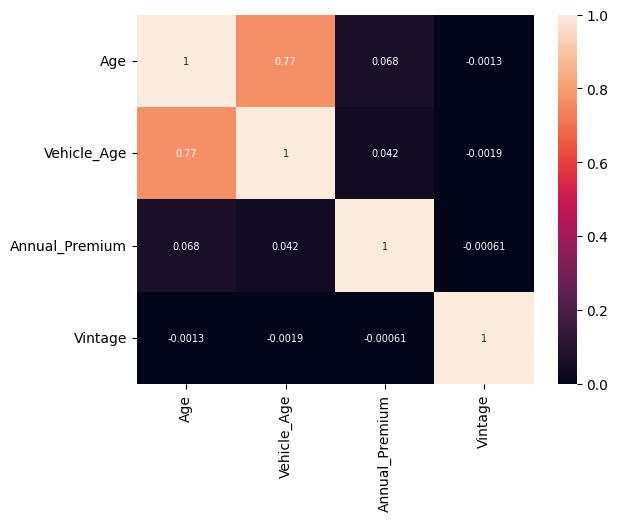

In [ ]:
df_corr = df[["Age", "Vehicle_Age", "Annual_Premium", "Vintage"]]
sns.heatmap(df_corr.corr(), annot=True, annot_kws={"fontsize": 7})

Considering variables Age, Vehicle Age, Annual Premium and Vintage, there is no sign of correlation between them, except between Age and Vehicle_Age which present a correlation coefficient of 0.77. </br>
We create hereafter a boxplot to investigate this relation. </br>
We note the independence between Annual Premium and Age (older people could have a higher amount of health insurance to pay, but it is not true here).

### Age vs Vehicle Age

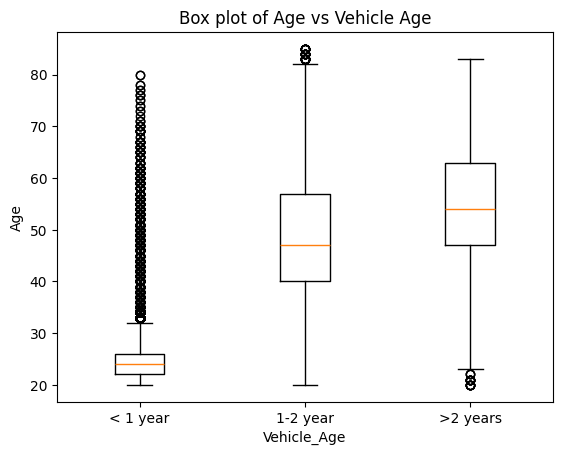

In [ ]:
labels = ['< 1 year', '1-2 year', '>2 years']

# Group data by 'Vehicle_Age' value and creation of a list of lists for boxplot
data = [df['Age'][df['Vehicle_Age'] == i] for i in range(3)]

fig, ax = plt.subplots()
ax.set_ylabel('Age')
ax.set_xlabel('Vehicle_Age')
bplot = ax.boxplot(data, patch_artist=False, tick_labels=labels)
ax.set_title("Box plot of Age vs Vehicle Age")
plt.show()

The high value of correlation coefficient is due to the fact that often people buy a car and keep it through the years. It is specifically visible that younger clients have new (<1 year old) vehicle. </br>
Nevertheless, there are so many outliers. </br>

###  Age vs Response

First, we plot the Age distribution with the target visualization.

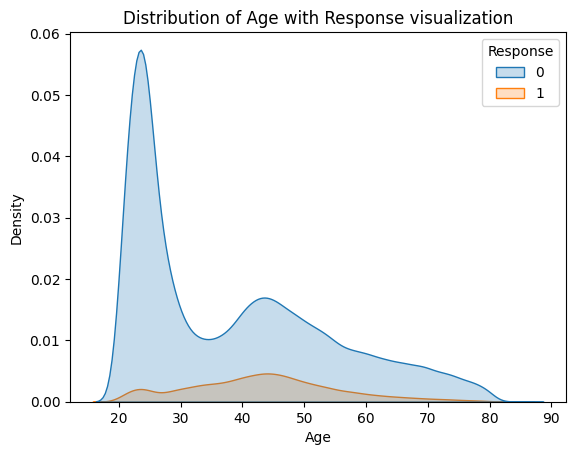

In [ ]:
data = df[["Age", "Response"]]

# Creation of the conditional density plot
sns.kdeplot(data=data, x='Age', hue='Response', fill=True)

# Plot show
plt.title('Distribution of Age with Response visualization')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

We observe here that, proportionnaly, there are very few clients with age in range [20-30] years old that subscribe to a vehicle insurance ; whereas in the second peak of population corresponding to [40-50] years old range, much more answered yes to the new policy.

In order to check this correlation, a T-test is performed.

In [ ]:
corr_quant_qual(df, ["Age"], ["Response"])

T-statistic: 69.04
P-value: 0.0


As the p-value is equal to 0, the correlation between variables Age and Response is confirmed.

In [ ]:
print(f"Mean age of clients answering Yes: {df[df['Response']==df['Response'].unique()[0]]['Age'].mean():.0f} years old; while for clients answering No: {df[df['Response']==df['Response'].unique()[1]]['Age'].mean():.0f} years old.")

Mean age of clients answering Yes: 43 years old; while for clients answering No: 38 years old.


### Age vs Vehicle Damage

Correlation between variables Age and Vehicle Damage is studied, first with a conditioned density distribution.

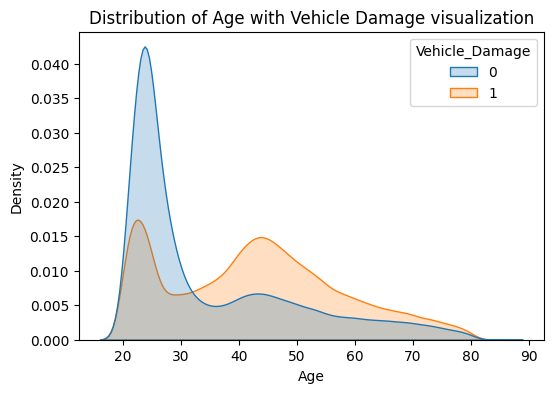

In [ ]:
data = df[["Age", "Vehicle_Damage"]]

# Creation of the conditional density plot
plt.figure(figsize=(6, 4))
sns.kdeplot(data=data, x='Age', hue='Vehicle_Damage', fill=True)

# Plot show
plt.title('Distribution of Age with Vehicle Damage visualization')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

In the 2 main Age populations the correlation with Vehicle Damage variable is different: </br>
* Youngest population: as clients are at the beginning of their driver lives, in proportions Vehicle Damage is low;
* Oldest population: as most probably, people drive since a longer time, the proportion of already experienced Vehicle Damage is much higher.

In order to put together the 2 previous plots, to represent variables Age, Vehicle_Damage and Response, a boxplot is created.

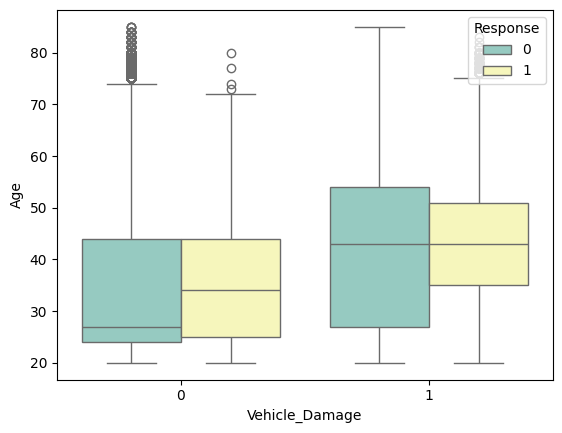

In [ ]:
sns.boxplot(x = df["Vehicle_Damage"], y = df["Age"], hue = df["Response"], palette="Set3")
plt.legend(title = "Response", loc='upper right')

Among people who never had Vehicle damage, younger clients mainly answer No to the vehicle policy, while older clients answer Yes (the median of Age is higher for the 1 Response than for the No).
On the other hand, for clients how already experienced vehicle damage, the median Age of both Response is the same.

### Vehicle Damage vs Response

To conclude about correlation between Vehicle Damage and Response, a chi-squared test is performed, and then a Cramer's V value is calculated.

In [ ]:
corr_qual(df['Vehicle_Damage'], df['Response'])

Chi2: 47864.76
p-value: 0.0
0.35


p-value chi-squared test equals to 0 means there is correlation between these 2 variables. </br>
A V's Cramer value equals to 0.35 shows that the correlation intensity is medium.

### Age vs Previously Insured

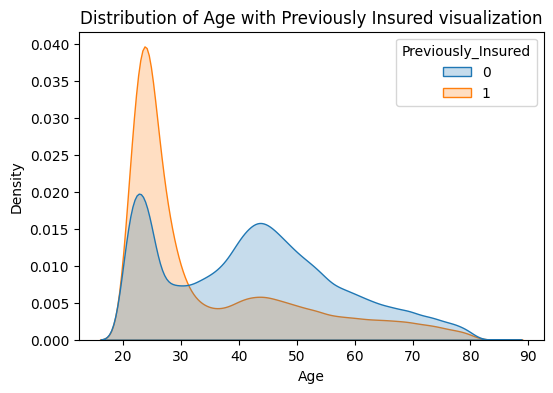

In [ ]:
data = df[["Age", "Previously_Insured"]]

# Creation of the conditional density plot
plt.figure(figsize=(6, 4))
sns.kdeplot(data=data, x='Age', hue='Previously_Insured', fill=True)

# Plot show
plt.title('Distribution of Age with Previously Insured visualization')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

The youngest population of this dataset in its majority already had an insured vehicle, while amoung the oldest one ([40-50] years old) it seems than less than half had already one. </br>
It would be interesting to see if there is correlation between Previously Insured variable and the Response.

### Previously Insured vs Response

In [ ]:
# Contingency table between the 2 variables
contingency_table = pd.crosstab(df["Previously_Insured"], df["Response"])
table_perc = round(contingency_table/df.shape[0]*100, 2)
print(table_perc)

Response                0      1
Previously_Insured              
0                   41.96  12.21
1                   45.78   0.04


We observe that in only 0.04% of the total cases correspond to a client who already have a vehicle insured and will subscribe to a new one. Previously Insured is definitively an important feature to predict the target. </br>
In order to check this statement, a chi-squared test is performed, followed by a Cramer's V value calculation.

In [ ]:
corr_qual(df['Previously_Insured'], df['Response'])

Chi2: 44357.96
p-value: 0.0
0.34


The chi-squared p-value equals to 0 indicates variables are correlated, and the Cramer's V indicates a medium intensity of correlation.

### Policy Sales Channel vs Age

We could hypothesize that the chosen channel to contact client depends on his age (for instance more social media for younger clients, more phone contact for the older ones).

In [ ]:
# ANOVA test
df_test = df[["Age", "Policy_Sales_Channel"]]

model = ols('Age ~ C(Policy_Sales_Channel)', data=df_test).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                               sum_sq        df            F  PR(>F)
C(Policy_Sales_Channel)  5.083584e+07     154.0  3077.485021     0.0
Residual                 4.086259e+07  380954.0          NaN     NaN


p-value of this ANOVA test (=0) indicates that there is relevant difference for the means of Age variable in function of Policy_Sales_Channel.

### Policy Sales Channel vs Response

To study the correlation between these 2 categorical features, we use a chi squared test.

In [ ]:
corr_qual(df['Policy_Sales_Channel'], df['Response'])

Chi2: 26447.03
p-value: 0.0
0.26


A p-value of 0 clearly means there is correlation between these 2 variables. </br> We can in fact imagine that some channels have low probability to be a success, while other much more. </br>
Cramer's V indicates a medium correlation.

### Gender vs Vehicle Damage

For curiosity, we investigate the relation between gender and vehicle damage.

In [ ]:
contingency_table = pd.crosstab(df["Vehicle_Damage"], df["Gender"])
table_perc = round(contingency_table/df.shape[0]*100, 2)
print(table_perc)

Gender              0      1
Vehicle_Damage              
0               24.49  25.02
1               29.58  20.90


The major category in this contingency table corresponds to male who already experienced vehicle damage, and the minor category represents female clients with previous episode of vehicle damage.

### Annual Premium vs Response

We can wonder if the amount of money paid for health insurance for the clients can influence their answer about subscribing vehicle policy.

(0.0, 70000.0)

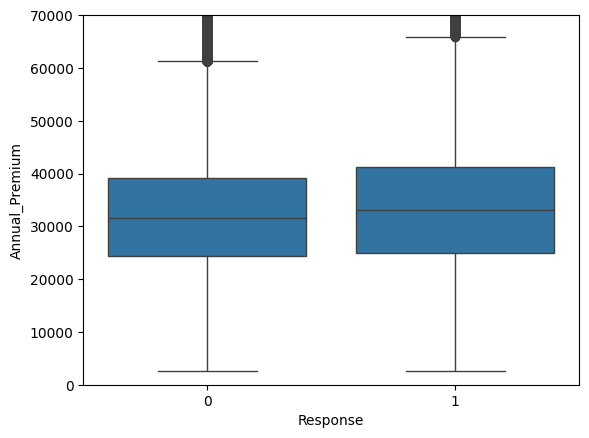

In [ ]:
sns.boxplot(x = df["Response"], y = df["Annual_Premium"])
plt.ylim(0,70000)
# as Annual_Premium has a lot of outliers in the upper values, we decide to limit the y scale to 70 000

In [ ]:
corr_quant_qual(df, ["Annual_Premium"], ["Response"])

T-statistic: 13.94
P-value: 3.7223151414267487e-44


From these results, as p-value is very close to 0, it means that Annual_Premium and Response are correlated.

In [ ]:
print(f" Mean value of Annual_Premium in group1 (negative answer from the client) : {df[df['Response']==0]['Annual_Premium'].mean():.2f}")
print(f" Mean value of Annual_Premium in group2 (positive answer from the client) : {df[df['Response']==1]['Annual_Premium'].mean():.2f}")

 Mean value of Annual_Premium in group1 (negative answer from the client) : 30419.16
 Mean value of Annual_Premium in group2 (positive answer from the client) : 31604.09


It means that clients paying higher health insurance are more aimed to subscribe the vehicle policy.

### Region Code vs Response

As in some geographic zones it may be easier to experience vehicle damage, these 2 variables may be correlated. To check it, a Chi squared test is performed, followed by a Cramer's V calculation.

In [ ]:
corr_qual(df['Region_Code'], df['Response'])

Chi2: 7267.84
p-value: 0.0
0.14


A correlation exists, as Chi-squared value is equal to 0, but the correlation is rather low (Cramer's V of 0.14).

### Vintage vs Response

In this case, we test the correlation between Vintage variable (from how long the person is a client of this insurance compagny) and Response. We can hypothesize that a client from longer time would be more easily attracted by a new policy, if satisfied by the compagny.

In [ ]:
corr_quant_qual(df, ["Vintage"], ["Response"])

T-statistic: -0.65
P-value: 0.5167036521412091


As p-value is equal to 0.52, there is no correlation. It can be due to the fact that the most experienced client in this compagny has less than one year of subscription (Vintage maximum value is 299 days).

### Driving License vs Response

In [ ]:
contingency_table = pd.crosstab(df["Driving_License"], df["Response"])
table_perc = round(contingency_table/df.shape[0]*100, 2)
print(table_perc)

Response             0      1
Driving_License              
0                 0.20   0.01
1                87.54  12.25


In [ ]:
print(f"Total percentage of clients without driving license subscribing to the policy: {table_perc.loc[0].sum():.2f} %")

Total percentage of clients without driving license subscribing to the policy: 0.21 %


Obviously, when the client doesn't have driving license, he will not subscribe a vehicle policy.

## EDA Conclusion

For each feature, the correlation with Response has been investigated and it appears that they all have some correlation. </br>
At this point, we decide to keep all of them, and don't cancel any for the model creation.


# Preprocessing

### Region_Code Feature

First, we group the modalities presenting less than 5 000 units in a class called "Others".

In [ ]:
df["Region_Code"] = df["Region_Code"].apply(lambda x: "Others" if region_counts[x] < 5000 else x)

Then, we perform OneHotEncoding.

In [ ]:
df = pd.get_dummies(df, columns = ["Region_Code"])

### Policy Sales Channel Feature

First, we group the modalities presenting less than 2 000 units in a class called "Others".

In [ ]:
df["Policy_Sales_Channel"] = df["Policy_Sales_Channel"].apply(lambda x: "Others" if channel_counts[x] < 2000 else x)

Then, we perform OneHotEncoding.

In [ ]:
df = pd.get_dummies(df, columns = ["Policy_Sales_Channel"])

## Missing data
It is important to verify if there are some missing data in the dataset.

In [ ]:
df.isna().sum()

,0
Gender,0
Age,0
Driving_License,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Vintage,0
Response,0
Region_Code_3.0,0


It seems that there is no missing data.

# Model Creation

## First 'Basic' Model

### Division Train and Test Sets

In [ ]:
RANDOM_SEED = 22
y = df['Response']
X = df.drop('Response', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_SEED, stratify=y)

### Standardization

 For the features: Age, Vehicle_Age,  Annual Premium and Vintage, we proceed to standardization, calculated on training set and applied on both training and test sets.

In [ ]:
transf = ColumnTransformer([('ss', StandardScaler(), [1, 4, 6, 7])], remainder='passthrough')
X_train = transf.fit_transform(X_train)
X_test = transf.transform(X_test)

### Model fitting

In [ ]:
model1 = LogisticRegression(random_state=RANDOM_SEED)
model1.fit(X_train, y_train)

LogisticRegression(random_state=22)

Model use with predict() and predict_proba() functions on both train and test sets.

In [ ]:
y_pred_train = model1.predict(X_train)
y_proba_train = model1.predict_proba(X_train)[:, 1]
y_pred_test = model1.predict(X_test)
y_proba_test = model1.predict_proba(X_test)[:, 1]

### Metrics

#### Classification reports

In [ ]:
print(classification_report(y_train, y_pred_train, digits = 4))

              precision    recall  f1-score   support

           0     0.8775    0.9997    0.9346    267519
           1     0.3429    0.0010    0.0019     37368

    accuracy                         0.8773    304887
   macro avg     0.6102    0.5004    0.4683    304887
weighted avg     0.8120    0.8773    0.8203    304887



In [ ]:
print(classification_report(y_test, y_pred_test, digits = 4))

              precision    recall  f1-score   support

           0     0.8775    0.9999    0.9347     66880
           1     0.5625    0.0010    0.0019      9342

    accuracy                         0.8775     76222
   macro avg     0.7200    0.5004    0.4683     76222
weighted avg     0.8389    0.8775    0.8204     76222



For this model, a precision of 34% and 56% on train and test sets are quite low results.  </br>
The worst value in these reports is the recall data equals to 0.10%. It means that among all the positive values, only 0.10% had been classified as positive. </br>
A confusion matrix is created in order to have the details of the classes.

#### Confusion Matrix

In [ ]:
  def plot_confusion_matrix(y_true, y_pred, labels=['Negative Answer', 'Positive Answer']):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm,
                       index = labels,
                       columns = ['Pred ' + labels[0], 'Pred ' + labels[1]],
                       )
    sns.heatmap(df_cm, annot = True, fmt = "g")

    plt.text(0, -0.1, f"Precision: {cm[1][1]/(cm[1][1] + cm[0][1]):.4f}")
    plt.text(1, -0.1, f"Recall: {cm[1][1]/(cm[1][1] + cm[1][0]):.4f}")

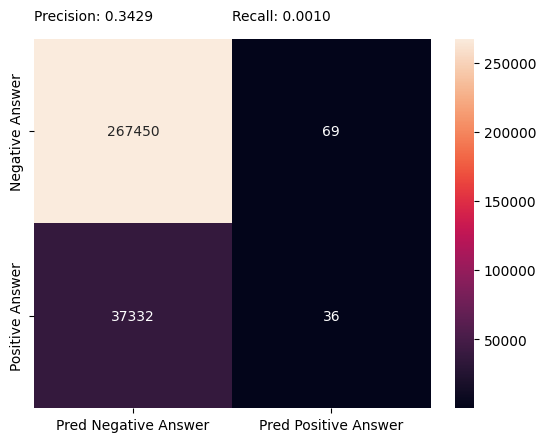

In [ ]:
plot_confusion_matrix(y_train, y_pred_train)

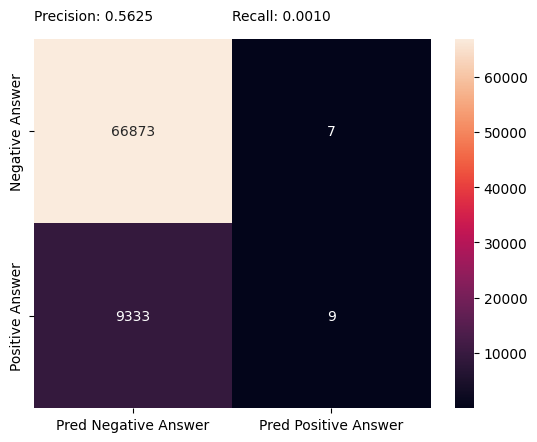

In [ ]:
plot_confusion_matrix(y_test, y_pred_test)

Here we can easily identified the biggest problem : it is crucial to limitate the false negative answers. In fact it is important to don't miss any potential client for the vehicle policy, even if it means increasing the number of false positives.

Special strategies have to be used to improve the model.

#### LogLoss

In [ ]:
print(f"Logloss for train set: {log_loss(y_train, y_proba_train):.2f}")
print(f"Logloss for test set: {log_loss(y_test, y_proba_test):.2f}")

Logloss for train set: 0.27
Logloss for test set: 0.27


For both train and test sets, the mean of probabilities obtained from model1 is 0.27.


#### AUC calculation

In [ ]:
print(f"AUC value for train set: {roc_auc_score(y_train, y_proba_train):.2f}")
print(f"AUC value for test set: {roc_auc_score(y_test, y_proba_test):.2f}")

AUC value for train set: 0.85
AUC value for test set: 0.85


## Second Model - class-weight argument of LogisticRegression

#### Model fitting

In [ ]:
model2 = LogisticRegression(class_weight="balanced", random_state=RANDOM_SEED)
model2.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=22)

In [ ]:
y_pred_train = model2.predict(X_train)
y_proba_train = model2.predict_proba(X_train)[:, 1]
y_pred_test = model2.predict(X_test)
y_proba_test = model2.predict_proba(X_test)[:, 1]

#### Metrics

In [ ]:
print(classification_report(y_train, y_pred_train, digits = 4))

              precision    recall  f1-score   support

           0     0.9864    0.6572    0.7888    267519
           1     0.2759    0.9351    0.4260     37368

    accuracy                         0.6912    304887
   macro avg     0.6311    0.7961    0.6074    304887
weighted avg     0.8993    0.6912    0.7443    304887



In [ ]:
print(classification_report(y_test, y_pred_test, digits = 4))

              precision    recall  f1-score   support

           0     0.9871    0.6563    0.7884     66880
           1     0.2761    0.9385    0.4267      9342

    accuracy                         0.6909     76222
   macro avg     0.6316    0.7974    0.6075     76222
weighted avg     0.8999    0.6909    0.7441     76222



This model gives for both sets precisions of 0.28 (lower than model1) but the recall value is much more important for this study and is equal to nearly 94%, which means that on 100 clients who answered yes, 94 would have been predicted as, following this model. </br>
F1 scores increased as well, nearly of 43%.



In [ ]:
print(f"Logloss for train set: {log_loss(y_train, y_proba_train):.2f}")
print(f"Logloss for test set: {log_loss(y_test, y_proba_test):.2f}")

Logloss for train set: 0.48
Logloss for test set: 0.48


Log loss values increased a lot, sign of a better model.

Let's try to modify the threshold value and see if we can increase the model metrics.

### Threshold modification

We focus on precision, recall and F1 score as metrics to check if there would be a better threshold value instead of the 0.5 default value.

In [ ]:
for threshold in np.arange(0.2, 0.8, 0.2):
  y_pred_train = np.where(y_proba_train>threshold, 1, 0)
  y_pred_test = np.where(y_proba_test>threshold, 1, 0)

  cm_train = confusion_matrix(y_train, y_pred_train)
  cm_test = confusion_matrix(y_test, y_pred_test)

  prec_train = cm_train[1][1]/(cm_train[1][1] + cm_train[0][1])
  rec_train = cm_train[1][1]/(cm_train[1][1] + cm_train[1][0])
  F1_train = 2*(prec_train*rec_train)/(prec_train+rec_train)

  prec_test = cm_test[1][1]/(cm_test[1][1] + cm_test[0][1])
  rec_test = cm_test[1][1]/(cm_test[1][1] + cm_test[1][0])
  F1_test = 2*(prec_test*rec_test)/(prec_test+rec_test)

  print(f"Threshold of {threshold:.1f}: TRAIN SET: Precision = {prec_train:.2f}, recall = {rec_train:.2f}, F1 = {F1_train:.2f}")
  print(f"\t\t\tTEST SET: Precision = {prec_test:.2f}, recall = {rec_test:.2f}, F1 = {F1_test:.2f}")


Threshold of 0.2: TRAIN SET: Precision = 0.24, recall = 0.99, F1 = 0.39
			TEST SET: Precision = 0.24, recall = 0.99, F1 = 0.39
Threshold of 0.4: TRAIN SET: Precision = 0.26, recall = 0.97, F1 = 0.41
			TEST SET: Precision = 0.26, recall = 0.97, F1 = 0.41
Threshold of 0.6: TRAIN SET: Precision = 0.30, recall = 0.87, F1 = 0.44
			TEST SET: Precision = 0.30, recall = 0.87, F1 = 0.44
Threshold of 0.8: TRAIN SET: Precision = 0.36, recall = 0.18, F1 = 0.24
			TEST SET: Precision = 0.36, recall = 0.18, F1 = 0.24


It is important to limit the number of false negative (high recall value), but it doesn't mean we should let precision decreasing to much. </br>
As a matter of fact, the best threshold value seems to be between 0.4 and 0.6 threshold values, in order to have high recall but a good compromise with precision. </br>
As a conclusion, we keep a threshold of 0.5.
Here there is no sign of overfitting.

## Third model: Resampling

To apply the resampling method on this imbalanced dataset, a new model is created from the original dataset (we decide to don't keep the class-weight argument in the logistic regression formation model to don't use 2 methods together which should treat the same problem).

Resampling helps to deal with imbalanced datasets. Both methods (oversampling and undersampling) present advantages and disadvantages. In order to limit both flaws, we decide to combine them.

### Resampling

In [ ]:
# Original dataset
y = df['Response']
X = df.drop('Response', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_SEED, stratify=y)

In [ ]:
# Resampling of the train set
over = RandomOverSampler(sampling_strategy = 0.5)
under = RandomUnderSampler(sampling_strategy = 'majority')
steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps = steps)

X_train, y_train = pipeline.fit_resample(X_train, y_train)

In [ ]:
# Standardization
transf = ColumnTransformer([('ss', StandardScaler(), [1, 4, 6, 7])], remainder='passthrough')
X_train = transf.fit_transform(X_train)
X_test = transf.transform(X_test)

### Model fitting

In [ ]:
# Creation model3
model3 = LogisticRegression(random_state=RANDOM_SEED)
model3.fit(X_train, y_train)

LogisticRegression(random_state=22)

In [ ]:
y_pred_train = model3.predict(X_train)
y_proba_train = model3.predict_proba(X_train)[:, 1]
y_pred_test = model3.predict(X_test)
y_proba_test = model3.predict_proba(X_test)[:, 1]

### Metrics

In [ ]:
print(classification_report(y_train, y_pred_train, digits = 4))

              precision    recall  f1-score   support

           0     0.9107    0.6575    0.7636    133759
           1     0.7320    0.9356    0.8213    133759

    accuracy                         0.7965    267518
   macro avg     0.8214    0.7965    0.7925    267518
weighted avg     0.8214    0.7965    0.7925    267518



In [ ]:
print(classification_report(y_test, y_pred_test, digits = 4))

              precision    recall  f1-score   support

           0     0.9871    0.6559    0.7881     66880
           1     0.2759    0.9389    0.4265      9342

    accuracy                         0.6905     76222
   macro avg     0.6315    0.7974    0.6073     76222
weighted avg     0.9000    0.6905    0.7438     76222



For model3, recall values are similar to what obtained with model2 (94%) but the precision values may indicate the risk of overfitting (precision and F1 score for train set >> for test set). </br>

The log loss is calculated to check this statement.


In [ ]:
print(f"Logloss for train set: {log_loss(y_train, y_proba_train):.2f}")
print(f"Logloss for test set: {log_loss(y_test, y_proba_test):.2f}")

Logloss for train set: 0.43
Logloss for test set: 0.48


On logloss there is no sign of overfitting.

## Fourth model: Feature selection through L1 regularization

 A last model is created from model3 with L1 regularization to perform some features selection, and try to reduce the gap between precision (and F1 score) between train and test sets.

### Model fitting

In [ ]:
# Creation model4
model4 = LogisticRegression(penalty='l1', solver='saga', C=.1, random_state=RANDOM_SEED)
model4.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', random_state=22, solver='saga')

In [ ]:
y_pred_train = model4.predict(X_train)
y_proba_train = model4.predict_proba(X_train)[:, 1]
y_pred_test = model4.predict(X_test)
y_proba_test = model4.predict_proba(X_test)[:, 1]

### Metrics

In [ ]:
print(classification_report(y_train, y_pred_train, digits = 4))

              precision    recall  f1-score   support

           0     0.9118    0.6566    0.7635    133759
           1     0.7317    0.9365    0.8215    133759

    accuracy                         0.7966    267518
   macro avg     0.8218    0.7966    0.7925    267518
weighted avg     0.8218    0.7966    0.7925    267518



In [ ]:
print(classification_report(y_test, y_pred_test, digits = 4))

              precision    recall  f1-score   support

           0     0.9872    0.6552    0.7876     66880
           1     0.2756    0.9394    0.4262      9342

    accuracy                         0.6900     76222
   macro avg     0.6314    0.7973    0.6069     76222
weighted avg     0.9000    0.6900    0.7433     76222



In [ ]:
print(f"Logloss for train set: {log_loss(y_train, y_proba_train):.2f}")
print(f"Logloss for test set: {log_loss(y_test, y_proba_test):.2f}")

Logloss for train set: 0.43
Logloss for test set: 0.48


There is no modification in the metrics using regularization.</br>
It is in agreement with the conclusions of the preliminary EDA part of this study that showed each features (except Vintage) are somehow correlated to the target.

# Conclusion

4 different models of logistic regression have been created in order to predict the response of the client about subscription to a vehicle policy:
* 1st basic model: very low recall, while it is precisly the value to increase here;
* 2nd model with class-weight = 'balanced': very good recall (94%) but still low precision (barely 28%). We tried to change the threshold value but it appears that 0.5 is the best compromise between high recall and not too low precision;
* 3rd model with resampling: very similar performance to model2, but some issues about performance difference between train adn test sets;
* 4th model with regularization: no change vs model3.</br>

As a conclusion, we can say that model2 is the best one. Used to predict the answer of clients, it would lead to high quantity of false positives, but there will be few false negatives, which is the aim here.